# EDA Datathon2021 by Softypo

In [2]:
# Importing module libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import dataframe_utilities as dfutil

## Data loading

In [3]:
# Global files
target_files = dfutil.loader_df('Data for Datathon\structured_data', index_col=0,)
# Eaglebine files
Eaglebine_files = dfutil.loader_df('Data for Datathon\Eaglebine\Eaglebine', index_col=0)
# Duvernay files
Duvernay_files = dfutil.loader_df('Data for Datathon\Duvernay\Duvernay', index_col=0)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
# master dataframe
df = target_files['set_assign']
# creating static/synthetic cathegory
df['source'] = pd.Series(['static' if ~np.isnan(row) else 'synthetic' for row in target_files['set_assign'].join(target_files['Data_static_logs'])['Temp (degC)']], dtype="category", index=df.index)
#target_files['combined_temperature'].rename(columns = {'Depth_SS(m)':'BHT_ss_m'}, inplace = True)

## tweaks and fixs

In [5]:
# fixing this one file set index
target_files['combined_temperature'].set_index('UWI', inplace=True)
# fixing this one file index column name
Eaglebine_files['Eaglebine_well_headers'].reset_index(inplace=True)
Eaglebine_files['Eaglebine_well_headers'].set_index('displayapi', inplace=True)
# fixing this one file index column values
Eaglebine_files['EagleBine_Casing_production'].index = Eaglebine_files['EagleBine_Casing_production'].index*10000
# triming spaces in these files
Duvernay_files['Duvernay_well_headers'].rename(columns=lambda x: x.strip(), inplace=True)
Eaglebine_files['Eaglebine_production'].rename(columns=lambda x: x.strip(), inplace=True)
Duvernay_files['SPE_Duvernay_production'].rename(columns=lambda x: x.strip(), inplace=True)

# computing ft and m references
Eaglebine_files['Eaglebine_well_headers']['Elevation_KB_meters'] = Eaglebine_files['Eaglebine_well_headers']['Elevation']*0.3048
Duvernay_files['Duvernay_well_headers']['Elevation_KB_ft'] = Duvernay_files['Duvernay_well_headers']['Elevation Meters']*3.28084
Duvernay_files['Duvernay_well_headers']['TD_ft'] = Duvernay_files['Duvernay_well_headers']['TD meters']*3.28084

Eaglebine_files['Eaglebine_BHT']['TD_meters'] = Eaglebine_files['Eaglebine_BHT']['TD (ft)']*0.3048


# computing bht depth at md
Eaglebine_files['Eaglebine_BHT']['BHT_ss_m'] = Eaglebine_files['Eaglebine_BHT']['BHT_below sea level (ft)']*0.3048
Eaglebine_files['Eaglebine_BHT']['BHT_md_ft'] = Eaglebine_files['Eaglebine_BHT']['BHT_below sea level (ft)']+Eaglebine_files['Eaglebine_well_headers']['Elevation']
Eaglebine_files['Eaglebine_BHT']['BHT_md_m'] = Eaglebine_files['Eaglebine_BHT']['BHT_md_ft']*0.3048
Duvernay_files['Duvernay_BHT']['BHT_md_m'] = (Duvernay_files['Duvernay_BHT']['DST Start Depth (MD) (m)']+Duvernay_files['Duvernay_BHT']['DST End Depth (MD) (m)'])/2
Duvernay_files['Duvernay_BHT']['BHT_md_ft'] = Duvernay_files['Duvernay_BHT']['BHT_md_m']*3.28084
Duvernay_files['Duvernay_BHT']['BHT_ss_m'] = -1*(Duvernay_files['Duvernay_BHT']['elevation M above sea level']-Duvernay_files['Duvernay_BHT']['BHT_md_m'])
Duvernay_files['Duvernay_BHT']['BHT_ss_ft'] = Duvernay_files['Duvernay_BHT']['BHT_ss_m']*3.28084

#renaming columns
Eaglebine_files['Eaglebine_well_headers'].rename(columns = {'Elevation':'Elevation_KB_ft'}, inplace = True)
Duvernay_files['Duvernay_well_headers'].rename(columns = {'Elevation Meters':'Elevation_KB_meters'}, inplace = True)
Duvernay_files['Duvernay_well_headers'].rename(columns = {'TD meters':'TD_meters'}, inplace = True)
Eaglebine_files['Eaglebine_well_headers'].rename(columns = {'Elevation':'Elevation_KB_ft'}, inplace = True)

Eaglebine_files['Eaglebine_BHT'].rename(columns = {'TD (ft)':'TD_ft'}, inplace = True)
Eaglebine_files['Eaglebine_BHT'].rename(columns = {'BHT_below sea level (ft)':'BHT_ss_ft'}, inplace = True)
Duvernay_files['Duvernay_BHT'].rename(columns = {'Formation DSTd':'formation'}, inplace = True)
Eaglebine_files['EagleBine_Casing_production'].rename(columns = {'MinCasingSize\\':'MinCasingSize'}, inplace = True)

# computing formation at bht depth from Eaglebine_tops
Eaglebine_files['Eaglebine_BHT']['formation'] = Eaglebine_files['Eaglebine_tops'].iloc[:,9:28].isin(Eaglebine_files['Eaglebine_tops'].iloc[:,9:28].where(Eaglebine_files['Eaglebine_tops'].iloc[:,9:28].sub(Eaglebine_files['Eaglebine_BHT']['BHT_md_ft'], axis='index') < 0).max(axis=1)).idxmax(1)

#droping unused files
Duvernay_files.pop('Duvernay_tops')
Eaglebine_files.pop('Eaglebine_tops')
#droping duplicated rows
Eaglebine_files['Eaglebine_production'] = Eaglebine_files['Eaglebine_production'][~Eaglebine_files['Eaglebine_production'].index.duplicated(keep='first')]
Eaglebine_files['Eaglebine_mud'] = Eaglebine_files['Eaglebine_mud'][~Eaglebine_files['Eaglebine_mud'].index.duplicated(keep='last')]

## concealing names and dropping redundant columns

In [6]:
# well headers
Eaglebine_files['Eaglebine_well_headers'].drop(columns=['td'], inplace=True)

# BHT files
Eaglebine_files['Eaglebine_BHT'].drop(columns=['SurfLat', 'SurfLong', 'BHT_ subsurface (ft)', 'GL(ft)', 'BHTorMRT (maximum recorded temperature) oF'], inplace=True)
Duvernay_files['Duvernay_BHT'].drop(columns=['DST Start Depth (MD) (m)', 'DST End Depth (MD) (m)', 'DST Bottom Hole Temp. (degC)', 'Unnamed: 9', 'elevation M above sea level', 'UWI'], inplace=True)

# mud files
Eaglebine_files['Eaglebine_mud'].drop(columns=['TD', 'KB'], inplace=True)

# production files
Eaglebine_files['Eaglebine_production'].drop(columns=['Elevation', 'Measured Depth (ft)'], inplace=True)
Duvernay_files['SPE_Duvernay_production'].drop(columns=['Measured Depth (ft)', 'Elevation', 'Elevation Drill Floor (ft)', 'Elevation Ground (ft)', 'Elevation Kelly Bushing (ft)'], inplace=True)

# pressures files
Duvernay_files['Duvernay_Pressures'].drop(columns=['KB Elev (m)', 'DST Number', 'Formation DSTd',
       'DST Start Depth (TVD) (m)', 'DST End Depth (TVD) (m)',
       'DST Start Depth (MD) (m)', 'DST End Depth (MD) (m)', 'DST Test Date',
       'Test Type', 'DST Misrun', 'Misrun Problem Type', '1st Valve Open Time',
       '2nd Valve Open Time', '3rd Valve Open Time', '1st Shut-in Time',
       '2nd Shut-in Time', '3rd Shut-in Time', 'Pressure Recorder Depth (m)',
       'DST Bottom Hole Temp. (degC)', '1st Flow Pressure (kPa)',
       '2nd Flow Pressure (kPa)', '3rd Flow Pressure (kPa)',
       '1st Shut-in Pressure (kPa)', '1st Shut-in Initial Slope',
       '1st Shut-in Final Slope', '1st Shut-in Extrapolated Press (kPa)',
       '2nd Shut-in Pressure (kPa)', '2nd Shut-in Initial Slope',
       '2nd Shut-in Final Slope', '2nd Shut-in Extrapolated Press (kPa)',
       '3rd Shut-in Pressure (kPa)', '3rd Shut-in Initial Slope',
       '3rd Shut-in Final Slope', '3rd Shut-in Extrapolated Press (kPa)',
       'Maximum Shut-in Pressure (kPa)'], inplace=True)

## concatenating dataframes

In [7]:
# pre merge
df = dfutil.multimerge([df, target_files['combined_temperature']], how='left', left_index=True, right_index=True)
Eaglebine = dfutil.multimerge(Eaglebine_files, how='outer', left_index=True, right_index=True)
Duvernay = dfutil.multimerge(Duvernay_files, how='outer', left_index=True, right_index=True)
# fixing strange index behavior
Eaglebine.index = [str(idx) + '_' for idx in Eaglebine.index]
Duvernay.index = [str(idx) + '_' for idx in Duvernay.index]
df.index = [str(idx) + '_' for idx in df.index]
# post merge
df = dfutil.multimerge([df, pd.concat([Duvernay, Eaglebine], axis=0, join='outer', verify_integrity=True)], how='left', left_index=True, right_index=True)
# renaming index names to a common one
dfutil.renameIndex('UWI', df, inplace=True)
# returning to original index names
Eaglebine.index = [str(idx).rstrip(str(idx)[-1]) for idx in Eaglebine.index]
Duvernay.index = [str(idx).rstrip(str(idx)[-1]) for idx in Duvernay.index]
df.index = [str(idx).rstrip(str(idx)[-1]) for idx in df.index]

In [8]:
#lat long convertion
def wsg84tonad83(df):
    import pyproj
    #nad83 = pyproj.CRS("EPSG:4269")
    #wgs84= pyproj.CRS("EPSG:4326")
    transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:4269")
    return transformer.transform(df['WGS84Longitude'], df['WGS84Latitude'])

df['nad83Longitude'], df['nad83Latitude'] = wsg84tonad83(df)

df.SurfaceLongitude_NAD83.fillna(df.nad83Longitude, inplace=True)
df.SurfaceLatitude_NAD83.fillna(df.nad83Latitude, inplace=True)
df.BottomLongitude_NAD83.fillna(df.nad83Longitude, inplace=True)
df.BottomLatitude_NAD83.fillna(df.nad83Latitude, inplace=True)

df.drop(columns=['SurfaceLatitude_NAD27', 'SurfaceLongitude_NAD27', 'BottomLatitude_NAD27', 'BottomLongitude_NAD27', 'WGS84Latitude', 'WGS84Longitude', 'SurfLat', 'SurfLong', 'nad83Longitude', 'nad83Latitude'], inplace=True)

In [9]:
# droping equal value columns
dfutil.drop_unique(df, inplace=True, axis=1)

In [10]:
df.head(5)

,Set,source,BHT,TrueTemp,Depth_SS(m),Field,TD (ft),DST Test Date,Test Type,DST Misrun,...,spuddate,completiondate,cumoil,cumgas,cumwater,Mud Wt,MW@Depth(KB),Drilling Days,Liquid Injection Cum (bbl),Gas Injection Cum (mcf)
42021301990000,Validation_Testing,synthetic,73.333333,NaN,NaN,Eaglebine,6910.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.2,6910.0,NaN,NaN,NaN
100102606420W500,Validation_Testing,synthetic,27.780000,NaN,697.20,Duvernay,NaN,21850.0,DST,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100141705519W500,Validation_Testing,synthetic,83.330000,NaN,1348.90,Duvernay,NaN,25813.0,DST,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100141503621W400,Validation_Testing,synthetic,48.890000,NaN,408.15,Duvernay,NaN,21964.0,DST,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100043406718W500,Validation_Testing,synthetic,65.560000,NaN,1440.35,Duvernay,NaN,23066.0,DST,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# dataframe in meters
df_m = df.drop(columns=['Depth_SS(m)', 'TD (ft)', 'BHT_md_ft', 'BHT_ss_ft', 'Elevation_KB_ft', 'TD_ft'], inplace=False)

In [12]:
# dataframe in ft
df_ft = df.drop(columns=['Depth_SS(m)', 'TD (ft)', 'BHT_md_m', 'BHT_ss_m', 'Elevation_KB_meters', 'TD_meters'], inplace=False)

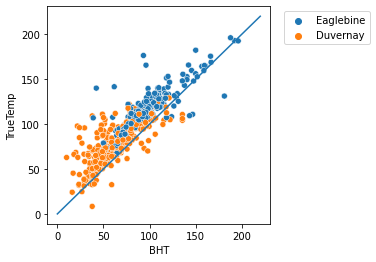

In [13]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=df, 
                x="BHT",
                y="TrueTemp",
                hue='Field', ax=ax)

ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [14]:
# exporting files for well logs EDA
df_m.to_csv('consolidated_well_data_Softypo_m.csv')
df_ft.to_csv('consolidated_well_data_Softypo_ft.csv')

## Creating master dataframe

In [15]:
# loading well logs file
well_logs = pd.read_csv('well_logs_Softypo.csv', index_col=0)

In [16]:
# concatenating final df
df_final = pd.concat([df_ft, well_logs], axis=1, join='outer', verify_integrity=True)
# renaming index
dfutil.renameIndex('UWI', df_final, inplace=True)

In [17]:
df_final

,Set,source,BHT,TrueTemp,Field,DST Test Date,Test Type,DST Misrun,DST Number,formation,...,Gas Injection Cum (mcf),GR,ILD,RHO,NPHI,DT,VSHALE,PHIT,SW,U
UWI,,,,,,,,,,,,,,,,,,,,,
42021301990000,Validation_Testing,synthetic,73.333333,NaN,Eaglebine,NaN,NaN,NaN,NaN,11_Buda_MD_ft,...,NaN,73.422600,9.77235,2.576150,0.185000,NaN,0.453019,0.131637,0.087182,NaN
100102606420W500,Validation_Testing,synthetic,27.780000,NaN,Duvernay,21850.0,DST,N,1.0,Kmannvl,...,NaN,48.028750,2.31870,NaN,NaN,122.822400,0.271634,0.493585,0.007834,NaN
100141705519W500,Validation_Testing,synthetic,83.330000,NaN,Duvernay,25813.0,DST,N,2.0,Kmannvl,...,NaN,71.541450,6.64715,NaN,NaN,92.898700,0.439582,0.297236,0.007249,NaN
100141503621W400,Validation_Testing,synthetic,48.890000,NaN,Duvernay,21964.0,DST,N,1.0,Kvik_ss,...,NaN,46.398625,6.77445,NaN,NaN,85.880150,0.259990,0.251182,0.013685,NaN
100043406718W500,Validation_Testing,synthetic,65.560000,NaN,Duvernay,23066.0,DST,Y,3.0,Dwabamun,...,NaN,19.313100,22.53665,NaN,NaN,53.188850,0.066522,0.036672,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100101606423W500,Training,synthetic,47.220000,56.340000,Duvernay,27801.0,DST,N,3.0,Kdunvegan,...,NaN,126.556100,6.70570,2.045650,0.387500,80.213800,0.832544,0.330003,0.004688,NaN
42177309850000,Training,synthetic,74.444444,96.655556,Eaglebine,NaN,NaN,NaN,NaN,12_Del_Rio_MD_ft,...,NaN,10.848950,28.64850,NaN,0.014200,NaN,0.006064,0.014200,1.000000,NaN
100100805919W500,Training,synthetic,69.440000,73.050000,Duvernay,28384.0,DST,N,1.0,Kmannvl,...,NaN,78.612650,13.41250,2.526800,0.243900,72.978800,0.490090,0.172521,0.015688,NaN


In [18]:
df_final.to_csv('final_well_data_Softypo_ft.csv')